# Topic Modeling

### Definition: 
*Topic modeling:* is a technique to extract the hidden topics from a corpus of documents, which can be derived from co-occurrences of words across the documents. It is a type of statistical model used for uncovering hidden structures in a collection of text. It can be summarised in the image below.

![title](img/tm.png)


### Important applications:
- *Text classification* – Topic modeling can improve classification by grouping similar words together in topics rather than using each word as a feature
- *Recommender Systems* – Using a similarity measure we can build recommender systems. If our system would recommend articles for readers, it will recommend articles with a topic structure similar to the articles the user has already read.
- *Uncovering Themes in Texts* – Useful for detecting trends in online publications for example.

Existing techiques for topic modeling include:Latent Dirichlet Allocation(LDA), Non Negative Matrix Factorization (NMF), Latent Semantic Analysis (LSA), Pachinko Allocation Model (PAM). The first two are the most used due to their advantages. For this presentation we shall focus on LDA. Below is a comparative analysis of the either behind LDA and NMF.
![title](img/types_of_tm_techniques.png)

## Latent Dirichlet Allocation(LDA):
This is the main and most frequently used algorithm for topic modeling. Based on the words used within a document, LDA mines topic level relations by assuming that a single document covers a small set of concise topics. Once learned, these topics often correlate well with human concepts. The diagram below gives us a good illustration of it's fonctioning.

![title](img/lda.png)

### Basic assumptions of the model: 

LDAs assumes that input corpora contain documents pertaining to a given number of topics, each of which are associated with a variety of words, and that each document is the result of a mixture of probabilistic samplings: first over the distribution of possible topics for the corpora, and second over the list of possible words in the selected topic.
- Each document is viewed as a mixture of topics
- Each topic is viewed as a mixture of words
- Documents have latent semantic structure (“topics”)
- Can infer topics from word-document co-occurrences
- Words are related to topics, topics to documents.


## Strengths and weaknesses of the LDA model

![title](img/lda2.png)

## Application on articles

Inspired from: https://github.com/AnushaMeka/NLP-Topic-Modeling-LDA-NMF/blob/master/Topic%20Modeling.ipynb

In [2]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import sys
import nltk
from nltk.corpus import stopwords
from gensim.models import ldamodel
import gensim.corpora
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import pickle
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import pyLDAvis.gensim
import warnings
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()
import numpy as np 
import pandas as pd
import string
import re
from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm
from collections import Counter,OrderedDict
from gensim import models,corpora
from gensim.summarization import summarize,keywords
import warnings
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.gensim
import gensim.models.phrases as gen
from gensim.models.coherencemodel import CoherenceModel

In [1]:
data=pd.read_csv('data/articles.csv')
len(data)

NameError: name 'pd' is not defined

In [5]:
data.head()

,author,claps,reading_time,link,title,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


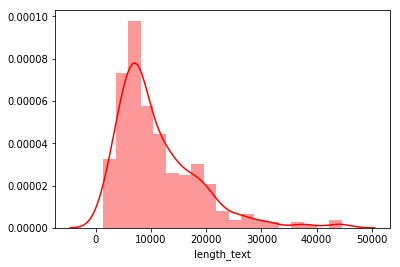

In [6]:
data['length_text'] = data['text'].str.len()
sns.distplot(data['length_text'], color="r")
plt.show()

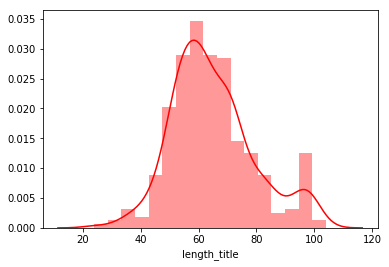

In [7]:
data['length_title'] = data['title'].str.len()
sns.distplot(data['length_title'], color="r")
plt.show()

In [8]:
titles = [x for x in data['title']]
docs = [x for x in data['text']]

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Data Preprocessing
We use NLTK’s Wordnet to find the meanings of words, synonyms, antonyms, and more. In addition, we use WordNetLemmatizer to get the root word. Filter out stop words.

In [11]:
# A function to prepare the text for topic modelling
def words(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    text = regex.sub(" ", text.lower())
    words = text.split(" ")
    words = [re.sub('\S*@\S*\s?', '', sent) for sent in words]
    words = [re.sub('\s+', ' ', sent) for sent in words]
    words = [re.sub("\'", "", sent) for sent in words]
    words = [w for w in words if not len(w) < 2]
    words = [w for w in words if w not in stop_words]
    words = [lmtzr.lemmatize(w) for w in words]
    
    return words

In [12]:
nltk.download('wordnet')
docs = [words(x) for x in data['text']]

[nltk_data] Downloading package wordnet to /Users/mac/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [13]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words in initital documents: 18975
Number of unique words after removing rare and common words: 2720


In [14]:
corpus = [dictionary.doc2bow(doc) for doc in docs]
#print(len(corpus))
#corpus[336]
bow_doc_300 = corpus[300]

for i in range(len(bow_doc_300)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_300[i][0], 
                                                     dictionary[bow_doc_300[i][0]], 
                                                     bow_doc_300[i][1]))

Word 47 ("close") appears 1 time.
Word 51 ("command") appears 1 time.
Word 65 ("cool") appears 1 time.
Word 121 ("gate") appears 1 time.
Word 189 ("multi") appears 1 time.
Word 213 ("predicted") appears 1 time.
Word 247 ("scene") appears 1 time.
Word 281 ("terminal") appears 1 time.
Word 321 ("column") appears 6 time.
Word 339 ("excellent") appears 1 time.
Word 370 ("matrix") appears 1 time.
Word 431 ("www") appears 1 time.
Word 434 ("additional") appears 1 time.
Word 455 ("collection") appears 3 time.
Word 489 ("github") appears 1 time.
Word 503 ("irrelevant") appears 1 time.
Word 506 ("learning”") appears 1 time.
Word 535 ("ready") appears 1 time.
Word 538 ("relationship") appears 3 time.
Word 571 ("“deep") appears 1 time.
Word 579 ("andrew") appears 1 time.
Word 617 ("guess") appears 1 time.
Word 652 ("neuron") appears 4 time.
Word 736 ("comprehensive") appears 1 time.
Word 767 ("enables") appears 1 time.
Word 774 ("explanation") appears 1 time.
Word 777 ("faced") appears 1 time.
Wo

## Topic Modeling using LDA
### Recap
LDA :: Latent Dirichlet Allocation is a probabilistic model. It is a unsupervised machine learning technique. And to obtain cluster assignments, it uses two probability values: P( word | topics) and P( topics | documents).

pyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.

The size of the bubble measures the importance of the topics, relative to the data. When we have 5 or 10 topics, we can see certain topics are clustered together (overlapping bubbles), this indicates the similarity between topics.

In [15]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [18]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary, #id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)


In [19]:
get_lda_topics(lda_model, 10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,neuron,star,cpu,de,cluster,bot,car,table,pixel,cnn
1,activation,review,house,member,agent,conversation,music,reward,woman,sheet
2,matrix,rating,gtx,sound,policy,behavior,graph,startup,men,box
3,zero,average,sentence,title,host,social,batch,recognize,convolution,region
4,player,weighted,gpu,speech,response,simulation,vehicle,array,kernel,pixel
5,policy,university,sequence,et,lstm,apps,track,tutorial,facial,bounding
6,man,interview,app,en,noise,interface,driving,translation,channel,mask
7,sigmoid,engineering,card,watson,trust,cognitive,placeholder,phrase,filter,proposal
8,derivative,programming,gpus,feed,reinforcement,response,song,distance,edge,segmentation
9,alphago,assignment,letter,netflix,unit,chatbots,computation,convolution,orientation,www


In [20]:
pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [22]:
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.067976 -0.041689       1        1  20.413773
0      0.027126  0.016758       2        1  14.546986
2      0.045037  0.138786       3        1  13.233190
1      0.058192 -0.077208       4        1  11.386016
6      0.071948  0.004281       5        1   8.606835
7      0.011309  0.092817       6        1   7.824125
3      0.065817  0.016241       7        1   7.326126
8     -0.032832 -0.253621       8        1   6.620484
4      0.058611  0.066103       9        1   6.452883
9     -0.373184  0.037532      10        1   3.589581, topic_info=     Category        Freq        Term       Total  loglift  logprob
734   Default  424.000000         cnn  424.000000  30.0000  30.0000
601   Default  322.000000          de  322.000000  29.0000  29.0000
29    Default  294.000000         box  294.000000  28.0000  28.0000
998   Default  288.000000       pixel  288.000000  27.0000  27.0000
420   Default  213.000000       table  213.000000  26.0000  26.0000
...       ...         ...         ...         ...      ...      ...
2538  Topic10   25.331270        kera  108.076653   1.8763  -5.0947
585   Topic10   24.627401      author  129.497055   1.6673  -5.1229
620   Topic10   21.000109    identify  103.424217   1.7328  -5.2822
999   Topic10   19.229012     pooling   90.166481   1.7819  -5.3703
1096  Topic10   20.629972  regression  144.100250   1.3834  -5.3000

[539 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
711       2  0.754960  activation
711       3  0.041431  activation
711       5  0.133499  activation
711       6  0.036827  activation
711       8  0.027620  activation
...     ...       ...         ...
2048      7  0.085910        “big
2048     10  0.042955        “big
1619      3  0.032358         “do
1619      7  0.048537         “do
1619      8  0.906025         “do

[2042 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 3, 2, 7, 8, 4, 9, 5, 10])

The above is the visual representation of the topic modelling and the below is the raw representation and we can specify #words with highest probability to display in each topic.

In [23]:
lda_model.save('model10.gensim')
topics = lda_model.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.019*"neuron" + 0.010*"activation" + 0.009*"matrix" + 0.008*"zero" + 0.008*"player" + 0.008*"policy"')
(1, '0.017*"star" + 0.015*"review" + 0.012*"rating" + 0.011*"average" + 0.010*"weighted" + 0.010*"university"')
(2, '0.010*"cpu" + 0.010*"house" + 0.009*"gtx" + 0.009*"sentence" + 0.009*"gpu" + 0.008*"sequence"')
(3, '0.034*"de" + 0.014*"member" + 0.012*"sound" + 0.011*"title" + 0.009*"speech" + 0.009*"et"')
(4, '0.014*"cluster" + 0.012*"agent" + 0.008*"policy" + 0.007*"host" + 0.007*"response" + 0.007*"lstm"')
(5, '0.011*"bot" + 0.006*"conversation" + 0.005*"behavior" + 0.005*"social" + 0.005*"simulation" + 0.004*"apps"')
(6, '0.011*"car" + 0.010*"music" + 0.008*"graph" + 0.008*"batch" + 0.007*"vehicle" + 0.006*"track"')
(7, '0.023*"table" + 0.009*"reward" + 0.008*"startup" + 0.007*"recognize" + 0.007*"array" + 0.006*"tutorial"')
(8, '0.020*"pixel" + 0.018*"woman" + 0.016*"men" + 0.015*"convolution" + 0.015*"kernel" + 0.011*"facial"')
(9, '0.095*"cnn" + 0.035*"sheet" + 0.035*"b

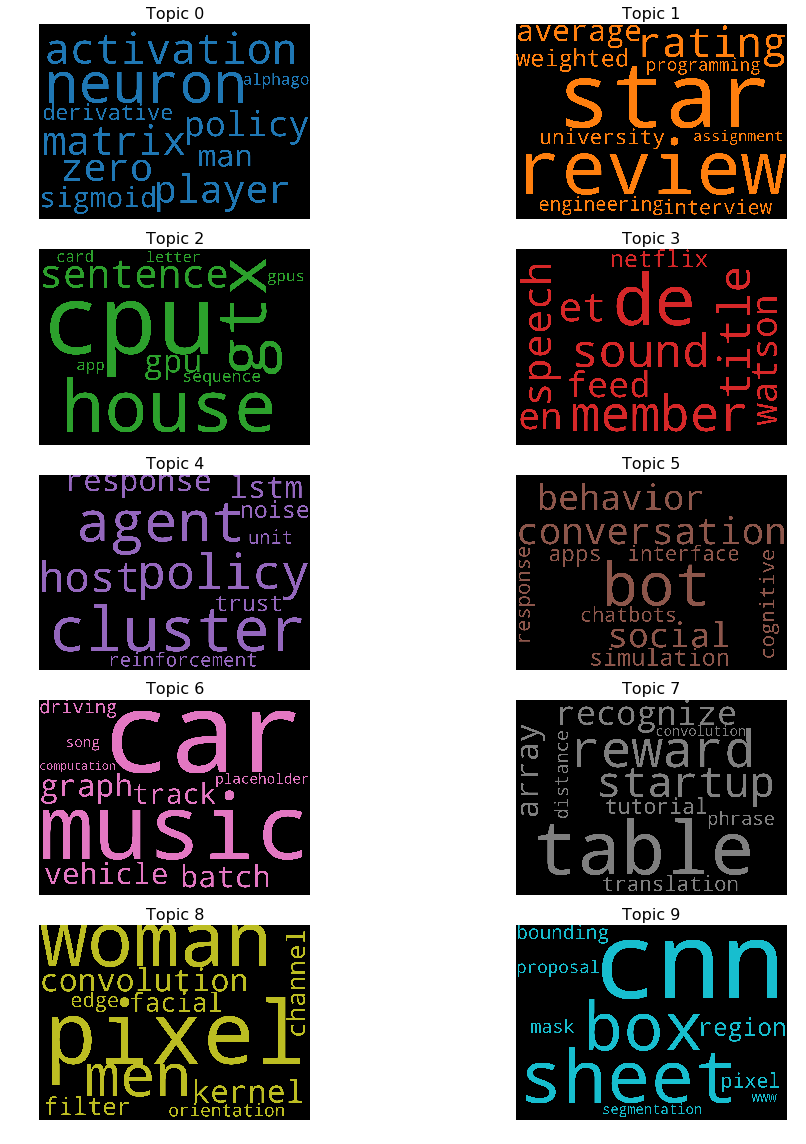

In [28]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'/TABLEAU_COLORS

cloud = WordCloud(#stopwords=stop_words,
                  #background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i])#,
                  #prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=10,num_words=10,formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(16,16), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    wc=cloud.generate_from_frequencies(topic_words)#, max_font_size=300)
    plt.gca().imshow(wc)#, interpolation='bilinear')
    plt.gca().set_title('Topic ' + str(i) , fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## References
- https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
- https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
- https://medium.com/ml2vec/topic-modeling-is-an-unsupervised-learning-approach-to-clustering-documents-to-discover-topics-fdfbf30e27df